# Spectroscopic Lensing: Flux Ratio Test

Testing the impact of different flux ratios

## Imports and Functions

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import medfilt

from astropy.table import Table, vstack, join
from astropy.io import fits

import desispec.io
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution
from desispec.spectra import Spectra

from desisim.templates import BGS, ELG

import redrock.templates
import redrock.results
from redrock.external import desi
 
from desi_myfunctions import *

import time

%matplotlib inline

In [2]:
def chkfile(cmd, outfile, overwrite=False):
    
    if os.path.exists(outfile) == True and overwrite == False:
        
        return None
    
    elif os.path.exists(outfile) == True and overwrite == True:
        
        !$cmd
    
    else:
        
        !$cmd
        
def setlims(x, y):
    
    if max(x) > max(y):
        maximum = max(x) + 0.2
    
    if max(x) < max(y):
        maximum = max(y) + 0.2
    
    if min(x) > min(y):
        minimum = min(y) - 0.2
    
    if min(x) < min(y):
        minimum = min(x) - 0.2
        
    lims = (minimum, maximum)
    
    return lims

In [3]:
start = time.time()

## Build and Combine Models

In [4]:
fileloc = os.path.join(os.getenv('HOME'), 'specLensing', 'fitsfiles', 'fratioTest_20fratios')
fratios = np.arange(0.01, 0.21, 0.01)

combwave = []
combflux = []
allBGSmeta = []
allELGmeta = []

for fratio in fratios:
    
    BGSmag = 20
    ELGseed = 50
    BGSseed = 79
    nrShifts = 5
    ELGmag = maggen(BGSmag, fratio)
    
    wave, flux, BGSmeta, ELGmeta = combspec(BGSmag=BGSmag, ELGmag=ELGmag, ELGseed=ELGseed, BGSseed=BGSseed, nrShifts=nrShifts, returnmeta=True)
    
    combwave.append(wave)
    combflux.append(flux)
    allBGSmeta.append(BGSmeta)
    allELGmeta.append(ELGmeta)

INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/bgs_templates_v2.3.fits
INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/elg_templates_v2.2.fits
INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/bgs_templates_v2.3.fits
INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/elg_templates_v2.2.fits
INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/bgs_templates_v2.3.fits
INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/elg_templates_v2.2.fits
INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/bgs_templates_v2.3.fits
INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templat

In [5]:
quickfiles = []

for i in range(len(combwave)):

    fitsfile = 'combined_spectra_data_{}.fits'.format(fratios[i])

    writefits(fileloc, fitsfile, combwave[i], 'Angstrom', hdrname='Wavelength', overwrite=True)
    writefits(fileloc, fitsfile, combflux[i], '10^-17 erg/(s*cm^2*Angstrom)', hdrname='Flux', overwrite=True)
    
    infile = os.path.join(fileloc, fitsfile)
    outfile = os.path.join(fileloc, 'quick_combdata_{}.fits'.format(fratios[i]))
    
    cmd = 'quickspectra -i {} -o {} --seeing 1.1 --airmass 1.1 --exptime 200'.format(infile, outfile)
    chkfile(cmd, outfile)
    
    quickfiles.append(outfile)

INFO:quickspectra.py:344:main: Reading an input FITS file
INFO:quickspectra.py:379:main: input flux shape = (5, 32001)
INFO:quickspectra.py:61:sim_spectra: Starting simulation of 5 spectra
INFO:iers.py:78:freeze_iers: Freezing IERS table used by astropy time, coordinates.
DEBUG:simexp.py:418:simulate_spectra: loading specsim desi config desi
DEBUG:simexp.py:422:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:444:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:448:simulate_spectra: obsconditions SEEING = 1.1
DEBUG:simexp.py:448:simulate_spectra: obsconditions EXPTIME = 200.0
DEBUG:simexp.py:448:simulate_spectra: obsconditions AIRMASS = 1.1
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONFRAC = 0.0
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONALT = -60
DEBUG:simexp.py:448:simulate_spectra: obsconditions MOONSEP = 180
DEBUG:simexp.py:490:simulate_spectra: running simulation with fastsim fiber loss metho

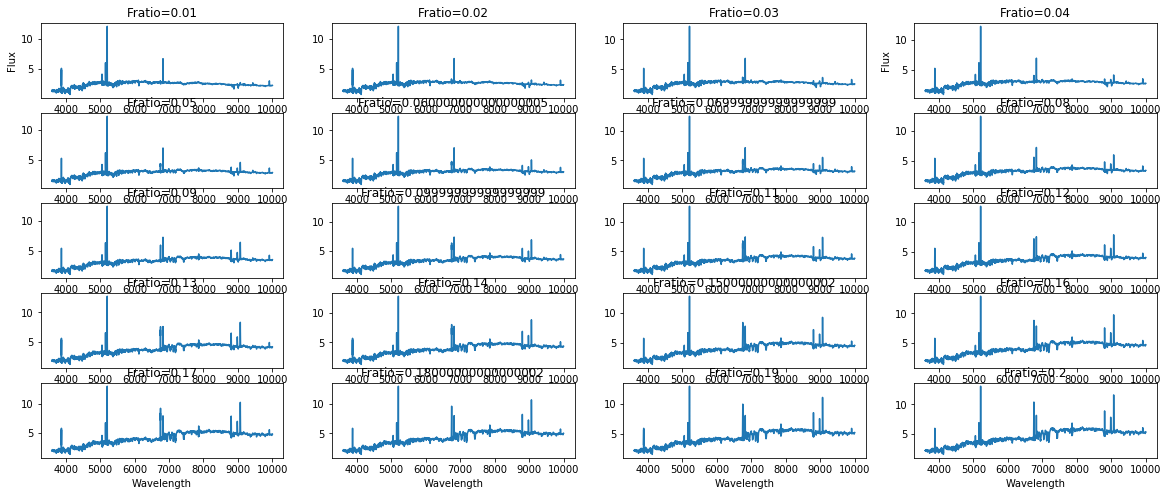

In [9]:
fig, ax = plt.subplots(5, 4, figsize=(20, 8))
ax = ax.flatten()
ax[0].set_ylabel('Flux')
ax[3].set_ylabel('Flux')

spectra = 0

for i in range(len(fratios)):
    
    ax[i].plot(combwave[0], combflux[i][spectra])
    ax[i].title.set_text('Fratio={}'.format(fratios[i]))
    
    if i >= 3:
        ax[i].set_xlabel('Wavelength')

## Run Redrock on Combined Spectra

In [31]:
zfiles = []
h5files = []

for file in quickfiles:
    
    zfile = os.path.join(fileloc, 'rrz_outfile_{}.fits'.format(file[len(fileloc)+16:-5]))
    h5file = os.path.join(fileloc, 'rrh5_outfile_{}.h5'.format(file[len(fileloc)+16:-5]))
    
    cmd = 'rrdesi {} -o {} -z {}'.format(file, h5file, zfile)
    chkfile(cmd, zfile)
    
    zfiles.append(zfile)
    h5files.append(h5file)

In [ ]:
zbest = []
BGSz = BGSmeta['REDSHIFT']
ELGz = ELGmeta['REDSHIFT']

fig, ax = plt.subplots(5, 4, figsize=(16,20))
ax = ax.flatten()
ax[0].set_ylabel('Real Z')
ax[3].set_ylabel('Real Z')

BGSfailperc = []

for ii in range(len(zfiles)):
    
    zdata = Table.read(zfiles[ii], 'ZBEST')
    zbest.append(zdata)
    
    zdata['dz'] = zdata['Z'] - BGSz
    rrfail = np.where(np.abs(zdata['dz']) > 0.003)[0]
    failrate = len(zdata[rrfail]) / len(zdata)
    BGSfailperc.append(failrate)
    
    dlim = setlims(zdata['Z'], BGSz)
    
    ax[ii].plot(zdata['Z'], BGSz, '.', label='Redrock Success')
    ax[ii].plot(zdata['Z'][rrfail], BGSz[rrfail], 'r.', label='Redrock Failure')
    ax[ii].title.set_text('Fratio={0:.2f}, {1:}% Failed'.format(fratios[ii], failrate*100))
    ax[ii].plot([dlim[0], dlim[1]], [dlim[0], dlim[1]], 'k--', alpha=0.4)
    ax[ii].legend()
    
    if ii >= 16:
        ax[ii].set_xlabel('Redrock Z')

## Subtract and Find new redrock Templates

In [35]:
tempflux = []
tempwave = []
specfiles = []

tempfile = redrock.templates.find_templates()[0]
rrtemp = redrock.templates.Template(tempfile, wave=combwave)

for i in range(len(quickfiles)):
    
    for k in range(len(zbest[i])):
        
        ncoeff = rrtemp.flux.shape[0]
        coeff = zbest[i]['COEFF'][k][:ncoeff]
        
        flux = rrtemp.flux.T.dot(coeff)
        wave = rrtemp.wave * (1+zbest[i]['Z'][k])
        tempflux.append(flux)
        tempwave.append(wave)
    
    specfile = rrtemp_to_spectra(quickfiles[i], tempfluxes=tempflux, tempwaves=tempwave, nrshifts=5)
    specfiles.append(specfile)

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


In [13]:
zfiles = {}
h5files = {}

for i in range(len(specfiles)):
    
    for file in specfiles[i]:
        
        zfile = os.path.join(fileloc, 'rrz_resdata_{}_{}.fits'.format(fratios[i], file[-1]))
        h5file = os.path.join(fileloc, 'rrh5_resdata_{}_{}.fits'.format(fratios[i], file[-1]))
        
        cmd = 'rrdesi {} -z {} -o {}'.format(file, zfile, h5file)
        chkfile(cmd, h5file)
        
        if zfiles.get(i) == None:
            
            zfiles[i] = [zfile]
            h5files[i] = [h5file]
            
        else:
            
            zfiles[i].append(zfile)
            h5files[i].append(h5file)

Running on a NERSC login node- reducing number of processes to 4
Running with 4 processes
Loading targets...
Read and distribution of 1 targets: 0.1 seconds
DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default re

In [14]:
reszbests = []

for i in range(len(quickfiles)):
    
    reszbest = []
    
    for file in zfiles[i]:
        
        zdata = Table.read(file, 'ZBEST')
        reszbest.append(zdata)
    
    reszbests.append(vstack(reszbest))

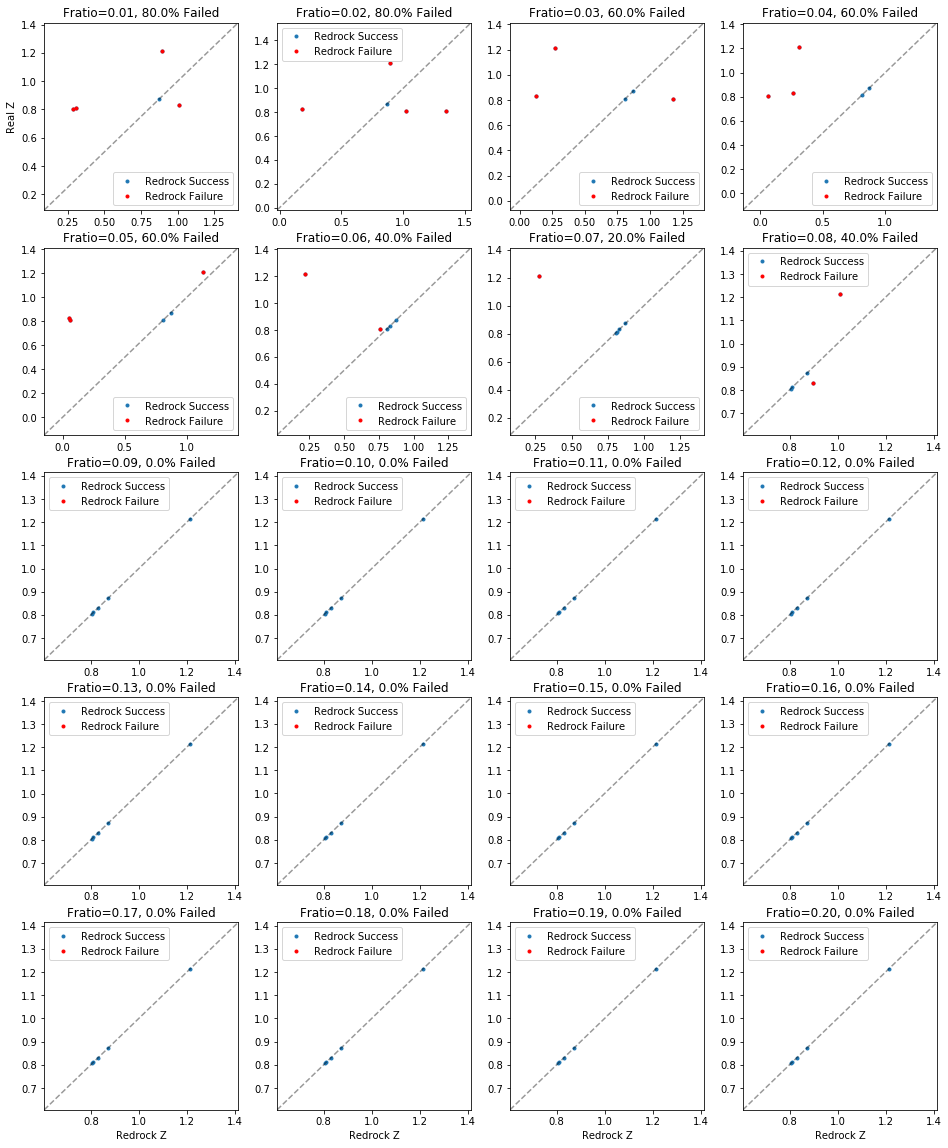

In [30]:
fig, ax = plt.subplots(5, 4, figsize=(16,20))
ax = ax.flatten()
ax[0].set_ylabel('Real Z')

failperc = []

for i in range(len(reszbests)):
    
    reszbests[i]['dz'] = reszbests[i]['Z'] - ELGz
    rrfail = np.where(np.abs(reszbests[i]['dz']) > 0.003)
    failrate = len(reszbests[i][rrfail]) / len(reszbests[i])
    failperc.append(failrate)
    
    dlim = setlims(reszbests[i]['Z'], ELGz)
    
    ax[i].plot(reszbests[i]['Z'], ELGz, '.', label='Redrock Success')
    ax[i].plot(reszbests[i]['Z'][rrfail], ELGz[rrfail], 'r.', label='Redrock Failure')
    ax[i].plot([dlim[0], dlim[1]], [dlim[0], dlim[1]], 'k--', alpha=0.4)
    ax[i].set_xlim(dlim)
    ax[i].set_ylim(dlim)
    ax[i].title.set_text('Fratio={0:.2f}, {1:}% Failed'.format(fratios[i], failrate*100))
    ax[i].legend()
    
    if i >= 16:
        ax[i].set_xlabel('Redrock Z')

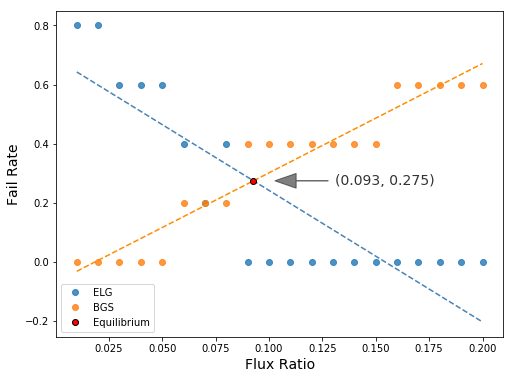

In [19]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(fratios, failperc, 'o', label='ELG', alpha=0.8)
ax.plot(fratios, BGSfailperc, 'o', label='BGS', alpha=0.8)
ax.set_ylabel('Fail Rate', fontsize=14)
ax.set_xlabel('Flux Ratio', fontsize=14)

fratiosnew = np.array(fratios).reshape(-1,1)
model = LinearRegression()

model.fit(fratiosnew, failperc)
ELGint = model.intercept_
ELGcoeff = model.coef_
yELGmodel = model.predict(fratiosnew)
ax.plot(fratios, yELGmodel, '--', color='steelblue')

model.fit(fratiosnew, BGSfailperc)
BGSint = model.intercept_
BGScoeff = model.coef_
yBGSmodel = model.predict(fratiosnew)
ax.plot(fratios, yBGSmodel, '--', color='darkorange')

point = find_intersect([ELGcoeff, BGScoeff], [ELGint, BGSint])
eqx, eqy = point[0]
ax.plot(eqx, eqy, 'ro', markeredgecolor='k', label='Equilibrium')

ax.arrow(eqx[0]+0.035, eqy[0], -0.015, 0, head_width=0.05, head_length=0.01, color='k', alpha=0.5, label='Eq')
ax.text(eqx[0]+0.038, eqy[0]-0.015, '({0:.3f}, {1:.3f})'.format(eqx[0], eqy[0]), fontsize=14, alpha=0.8)

ax.legend()

In [21]:
end = time.time()

hours = (end - start) / 3600
mins = (hours - int(hours)) * 60
sec = (mins - int(mins)) * 60

print('Runtime (hrs:min:sec) is {} : {} : {}'.format(int(hours), int(mins), sec))

Runtime (hrs:min:sec) is 1 : 29 : 37.04498100280773
